In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.spatial import ConvexHull, convex_hull_plot_2d 
from source_draft import preprocess as prep

from scipy.stats import entropy
from Bio import SeqIO

In [2]:
plt.rcParams.update({'font.family': 'Arial'})
plt.rcParams.update({'font.size': 9})

In [3]:
# functional threshold based on (mean_func - 2*std_func):
resc_func = 0.84158931 # where does this number come from? See EDA_partial_rescue

In [4]:
# Natural sequences
all_nat_df = pd.read_excel('data/20210908_natural_with_taxonomy.xls').iloc[:,1:]
in_training_set= pd.read_excel('../data/LibraryNatural.xls')['In Training Set']
nat_train_df = all_nat_df[in_training_set==1]
nat_train_df = nat_train_df.drop_duplicates(subset='Sequences')


In [5]:
func_all_nat_df = all_nat_df[all_nat_df.norm_RE > resc_func]

# sanity check: see if all of the functional 141 sequences are annotated as sho1
if  func_all_nat_df[func_all_nat_df['orthologous_group'] == 'NOG09120'].shape[0] == func_all_nat_df.shape[0]:
    
    print('Within the whole natural sho1 dataset, all of the functional sequences are annotated as sho1')
    
else:
    print('Within the whole natural sho1 dataset, all of the functional sequences are NOT annotated as sho1')
    

Within the whole natural sho1 dataset, all of the functional sequences are annotated as sho1


In [6]:

print('Number of annotated sho1 in the whole dataset versus only in the training dataset:',
    all_nat_df[ all_nat_df['orthologous_group'] == 'NOG09120' ].shape[0], nat_train_df[ nat_train_df['orthologous_group'] == 'NOG09120' ].shape[0]
)

Number of annotated sho1 in the whole dataset versus only in the training dataset: 178 164


In [7]:
# design sequences
design_df = pd.read_excel('../data/20220928_design_sheet.xlsx')
global_mmd_df = design_df[ design_df.header.str.contains('mmd_') ]
local_mmd_df = design_df[ design_df.header.str.contains('mmdlocal_') ]


#### Prepare sho1 natural sequences (paralog annotation, function, nonfunctional classification):

In [8]:
sho1_all_df = all_nat_df[all_nat_df['orthologous_group'] == 'NOG09120'] # number of sho1 naturals 
func_sho1_all_df = sho1_all_df[sho1_all_df.norm_RE > resc_func]
nonfunc_sho1_all_df = sho1_all_df[~(sho1_all_df.norm_RE > resc_func)]


In [9]:
# Sanity check: make sure natural functional and nonfunctional numbers make sense...

print('Number of functional natural sho1s within the whole dataset:', func_sho1_all_df.shape[0])
print('Number of functional natural sho1s within the whole dataset:', nonfunc_sho1_all_df.shape[0])
print('Number of annotated natural sho1s:', sho1_all_df.shape[0])
 

Number of functional natural sho1s within the whole dataset: 141
Number of functional natural sho1s within the whole dataset: 37
Number of annotated natural sho1s: 178


In [10]:
## Sanity check:
# make sure the number of fully rescued in the whole dataset equals the fully rescued in sho1 subset
func_nat_df = all_nat_df[all_nat_df.norm_RE > resc_func]
print('Number of functional natural SH3s within the whole dataset:', func_nat_df.shape[0])


Number of functional natural SH3s within the whole dataset: 141


## Helper Convex hull functions:

In [11]:
def compute_hull(data, hull):
    ix = np.where(data == hull)[0]
    coord = mmd_nat_coord[ix,:]
    return ConvexHull(coord)

def check_latent_in_hull(z_coord, hull, tolerance = 10**-12):
    decision = all((np.dot(equa[:-1], z_coord) + equa[-1] <= tolerance) for equa in hull.equations)
    return decision

def check_hull_list(l, hull):
    return np.array([check_latent_in_hull(i, hull) for i in l])

## Functional Sho1 convex hull:

In [12]:
# sanity check: Number of functional and non-functional sho1s. 
print('Number of functional Sho1 orthologs:', func_sho1_all_df.shape[0])
print('Number of non-functional Sho1 orthologs:', nonfunc_sho1_all_df.shape[0])


Number of functional Sho1 orthologs: 141
Number of non-functional Sho1 orthologs: 37


In [13]:
# all of these sequences are functonal sho1s
func_sho1_all_z = func_sho1_all_df[[f'MMD_z{ii}' for ii in range(3)]].values
nonfunc_sho1_all_z = nonfunc_sho1_all_df[[f'MMD_z{ii}' for ii in range(3)]].values


In [14]:
func_ortho_mmd = np.array(func_sho1_all_z)

# create convex hull based on functional natural sho1s (# 132)
func_ortho_hull = ConvexHull(func_ortho_mmd)

#### Check whether samples are in the hull or not

In [15]:
# check how many natural SH3 domains are in the convex hull

# check how many functinonal natural Sh3s are in the convex hull
func_sho1_in_hull = check_hull_list(
    func_sho1_all_z,
    func_ortho_hull
)
print(f'Number of functional SH3 domains in the convex hull: {sum(func_sho1_in_hull)}')

# check how many nonfunctinonal natural Sh3s (training dataset only) are in the convex hull

nonfunc_sho1_in_hull = check_hull_list(
    nonfunc_sho1_all_z,
    func_ortho_hull
)
print(f'Number of functional SH3 domains in the convex hull: {sum(nonfunc_sho1_in_hull)}')


Number of functional SH3 domains in the convex hull: 141
Number of functional SH3 domains in the convex hull: 23


## Make plots:

### Plot Sho1 sequences within the functional defined hull:

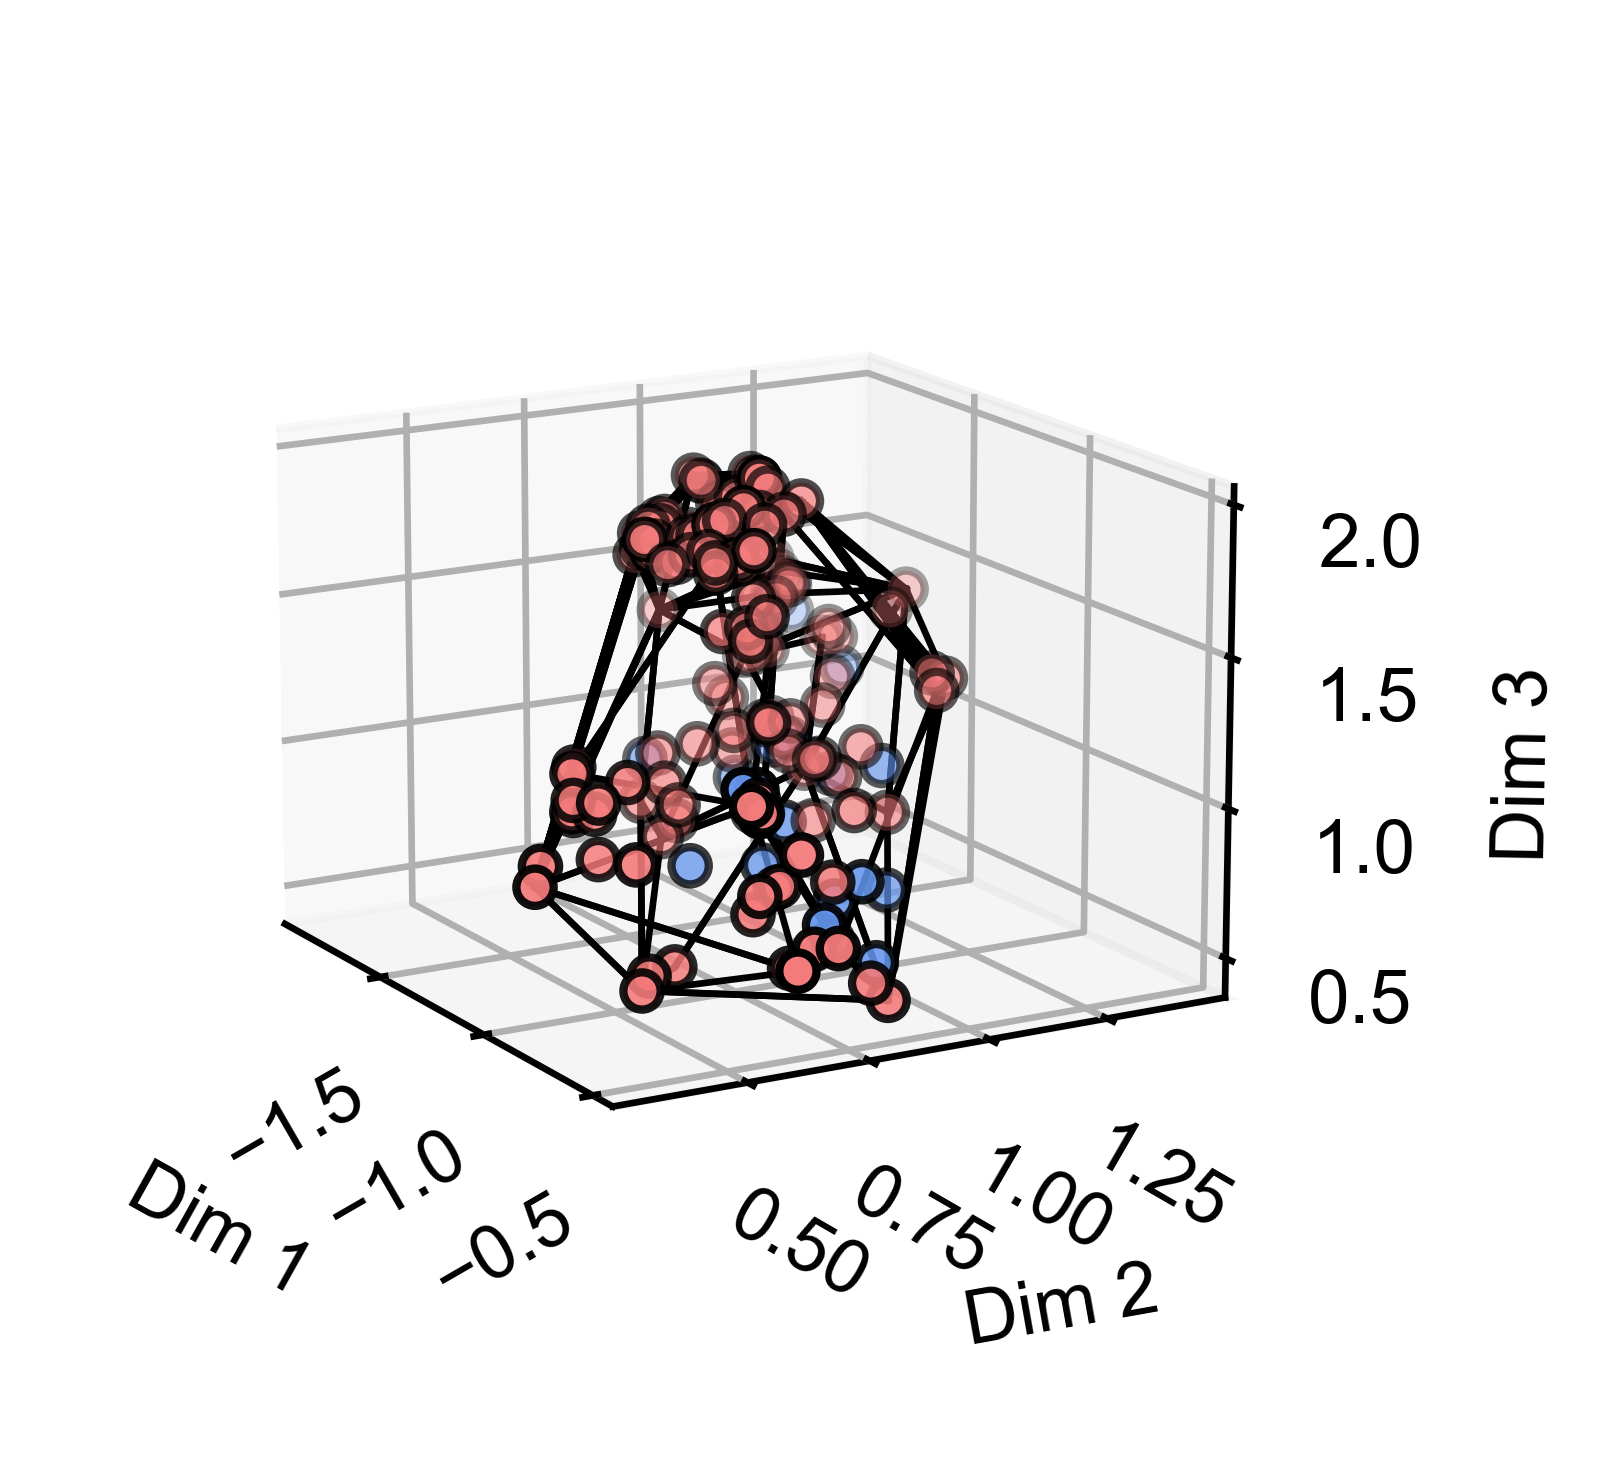

In [16]:
for fig_idx, rot_val in zip([0], [-30]):
    fig = plt.figure(figsize = (2.5,2.5),dpi = 600)

    ax = plt.axes(projection="3d")
    ax.view_init(15, rot_val)

    # plot all of the nonfunctional embeddings in the convex hull ...
    
    p = ax.scatter(
        nonfunc_sho1_all_z[nonfunc_sho1_in_hull, 0],
        nonfunc_sho1_all_z[nonfunc_sho1_in_hull, 1],
        nonfunc_sho1_all_z[nonfunc_sho1_in_hull, 2],
        c = 'cornflowerblue', 
        edgecolor = 'k', 
        s = 20
    )
                   
        
    
    # plot all of the functional embeddings in the convex hull ...
    p = ax.scatter(
        func_sho1_all_z[func_sho1_in_hull,0],
        func_sho1_all_z[func_sho1_in_hull,1], 
        func_sho1_all_z[func_sho1_in_hull,2],
        c='#f47b7b',
        edgecolor = 'k',
        s = 20
    )

    

    for simplex in func_ortho_hull.simplices:
        ax.plot(func_ortho_mmd[simplex, 0], func_ortho_mmd[simplex, 1],  func_ortho_mmd[simplex, 2], 'k-',lw=.8)

    ax.set_xlabel('Dim 1', labelpad=9)
    ax.set_ylabel('Dim 2', labelpad=9)
    ax.set_zlabel('Dim 3')
    ax.dist = 12.4
    plt.yticks(rotation=-30)
    plt.xticks([-1.5,-1,-.5],rotation=30)
plt.tight_layout()
#plt.savefig('figures/b.pdf')

### Plot the nonfunctional sho1s outside the convexhull:

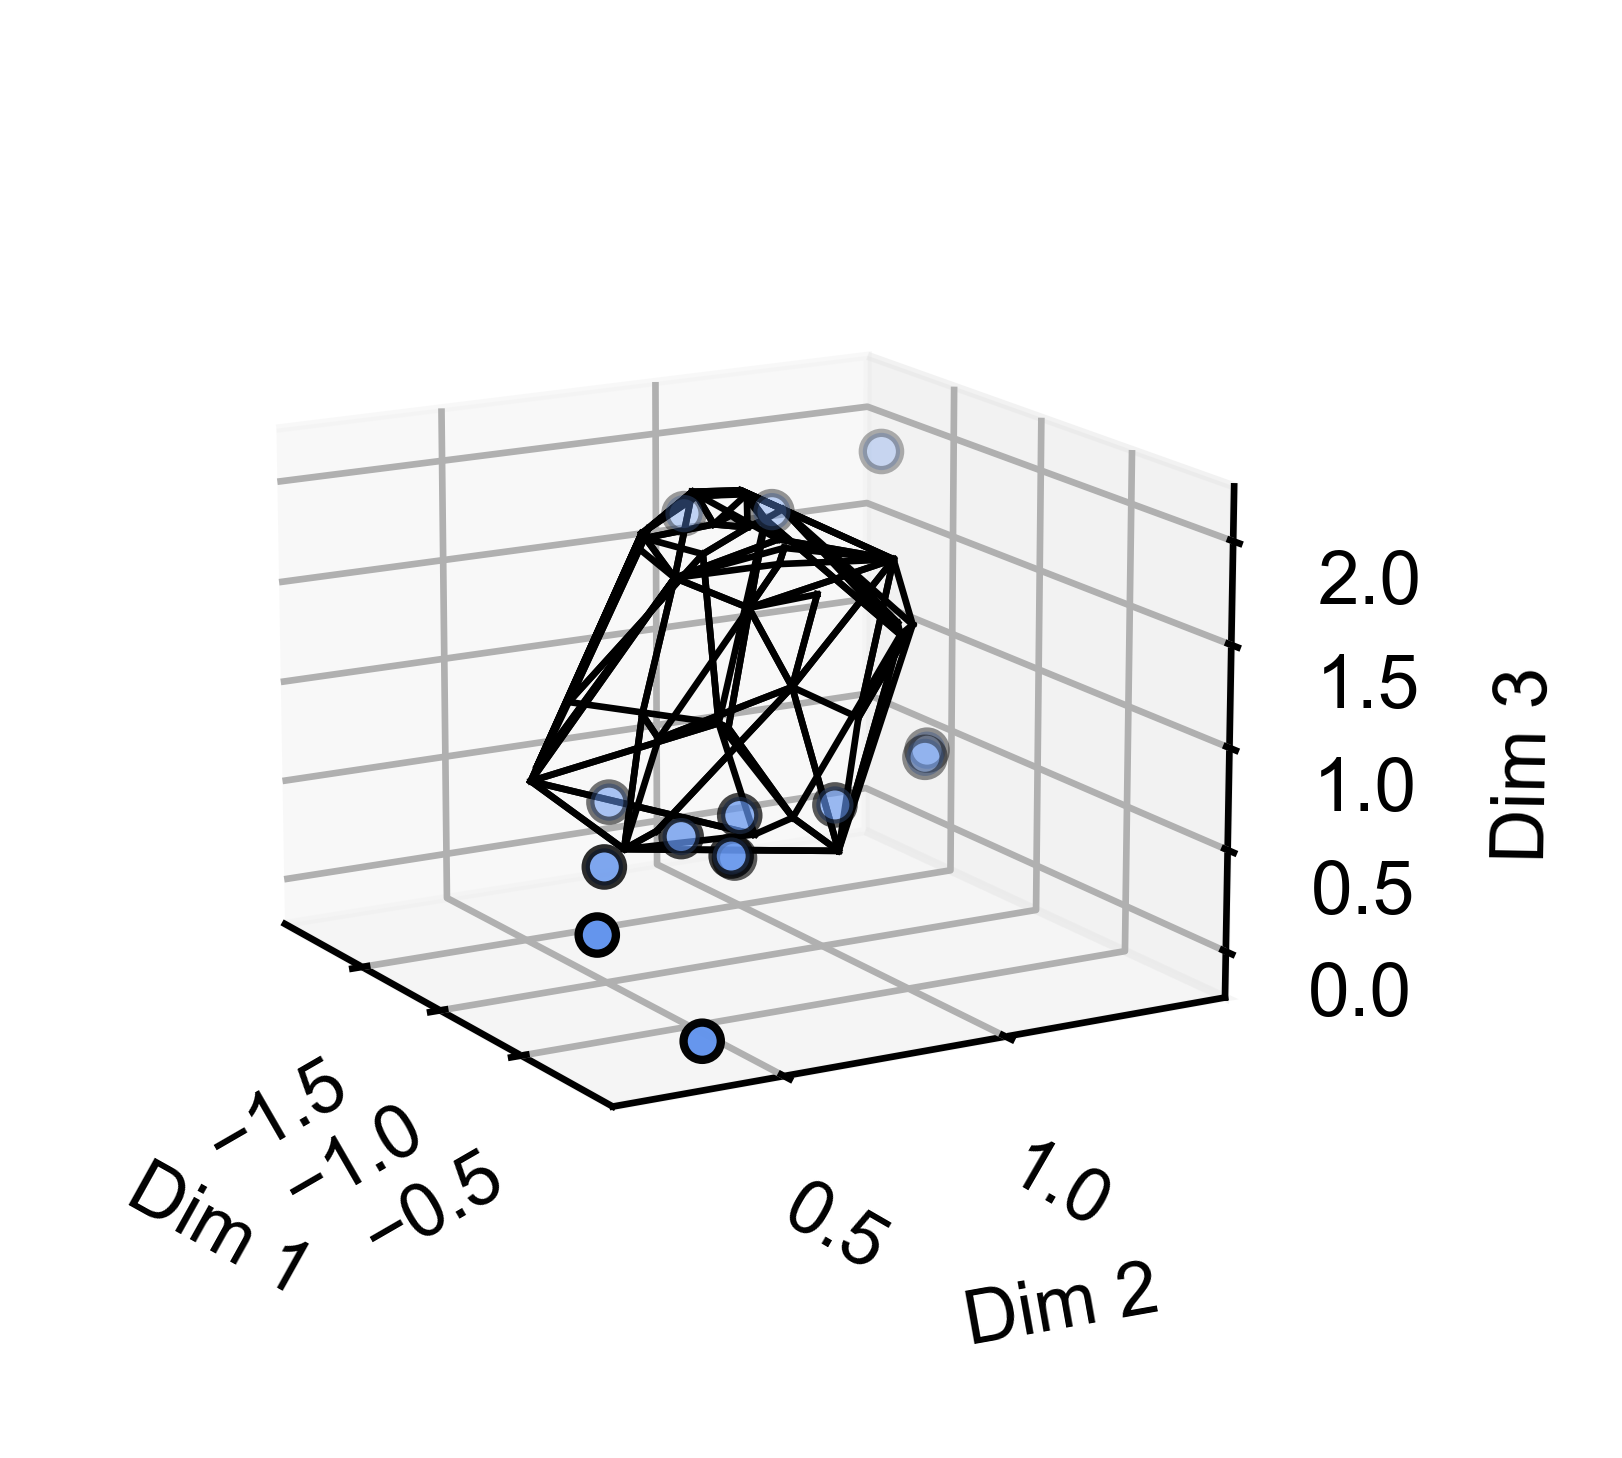

In [17]:
 for fig_idx, rot_val in zip([0], [-30]):
    fig = plt.figure(figsize = (2.5,2.5),dpi = 600)

    ax = plt.axes(projection="3d")
    ax.view_init(15, rot_val)

    # plot all of the nonfunctional embeddings in the convex hull ...
    
    p = ax.scatter(
        nonfunc_sho1_all_z[~nonfunc_sho1_in_hull, 0],
        nonfunc_sho1_all_z[~nonfunc_sho1_in_hull, 1],
        nonfunc_sho1_all_z[~nonfunc_sho1_in_hull, 2],
        c = 'cornflowerblue', 
        edgecolor = 'k', 
        s = 20
    )
                   
        
    
    # plot all of the functional embeddings in the convex hull ...
    p = ax.scatter(
        func_sho1_all_z[~func_sho1_in_hull,0],
        func_sho1_all_z[~func_sho1_in_hull,1], 
        func_sho1_all_z[~func_sho1_in_hull,2],
        c='#f47b7b',
        edgecolor = 'k',
        s = 20
    )

    

    for simplex in func_ortho_hull.simplices:
        ax.plot(func_ortho_mmd[simplex, 0], func_ortho_mmd[simplex, 1],  func_ortho_mmd[simplex, 2], 'k-',lw=.8)

    ax.set_xlabel('Dim 1', labelpad=9)
    ax.set_ylabel('Dim 2', labelpad=9)
    ax.set_zlabel('Dim 3')
    ax.dist = 12.4
    plt.yticks(rotation=-30)
    plt.xticks([-1.5,-1,-.5],rotation=30)
plt.tight_layout()
#plt.savefig('figures/b.pdf')

 ## Prepare Design Convex Hull analysis:

In [18]:
local_mmd_z = local_mmd_df[[f'MMD_z{ii}' for ii in range(3)]].values

# check how many functinonal natural Sh3s are in the convex hull
localmmd_in_hull = check_hull_list(
    local_mmd_z,
    func_ortho_hull
)
print(f'Number of local MMD designs in hull: {sum(localmmd_in_hull)}')


# inside/outside convex hull regardless
inhull_local_mmd_df = local_mmd_df.iloc[localmmd_in_hull]
outhull_local_mmd_df = local_mmd_df.iloc[~localmmd_in_hull]


# functional and nonfunctional embeddings within the hull
func_inhull_localmmd_df = inhull_local_mmd_df[inhull_local_mmd_df.RE_norm > resc_func]
func_inhull_localmmd_z = func_inhull_localmmd_df[[f'MMD_z{ii}' for ii in range(3)]].values

nonfunc_inhull_localmmd_df = inhull_local_mmd_df[~(inhull_local_mmd_df.RE_norm > resc_func)]
nonfunc_inhull_localmmd_z = nonfunc_inhull_localmmd_df[[f'MMD_z{ii}' for ii in range(3)]].values


print(f'Number of functional/nonfunctional in hull: {func_inhull_localmmd_df.shape[0]} and {nonfunc_inhull_localmmd_df.shape[0]}')

# functional and nonfunctional embeddings outside the hull
func_outhull_localmmd_df = outhull_local_mmd_df[outhull_local_mmd_df.RE_norm > resc_func]
func_outhull_localmmd_z = func_outhull_localmmd_df[[f'MMD_z{ii}' for ii in range(3)]].values

nonfunc_outhull_localmmd_df = outhull_local_mmd_df[~(outhull_local_mmd_df.RE_norm > resc_func)]
nonfunc_outhull_localmmd_z = nonfunc_outhull_localmmd_df[[f'MMD_z{ii}' for ii in range(3)]].values

print(f'Number of functional/nonfunctional out hull: {func_outhull_localmmd_df.shape[0]} and {nonfunc_outhull_localmmd_df.shape[0]}')


Number of local MMD designs in hull: 387
Number of functional/nonfunctional in hull: 294 and 93
Number of functional/nonfunctional out hull: 140 and 460


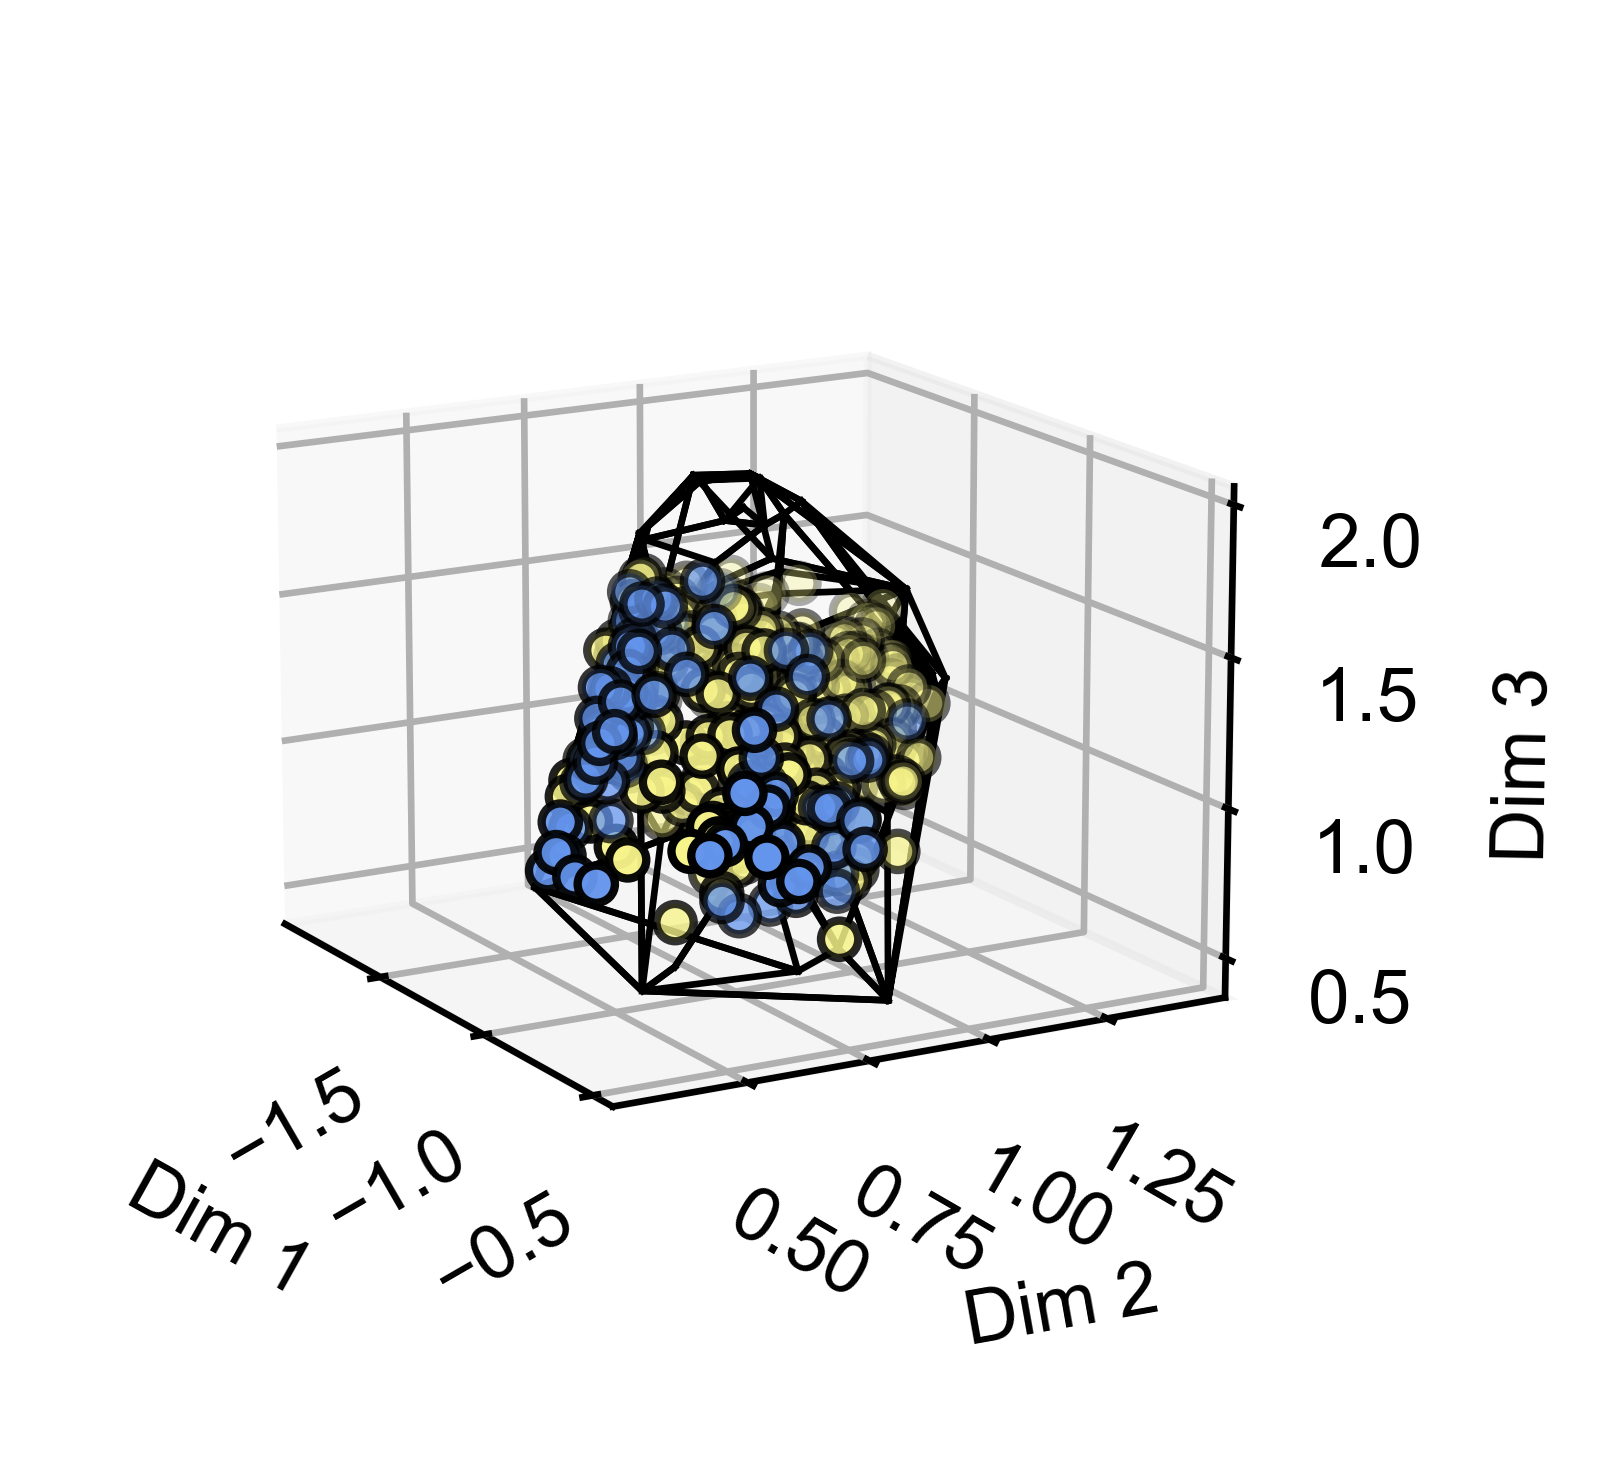

In [19]:
for fig_idx, rot_val in zip([0], [-30]):
    fig = plt.figure(figsize = (2.5,2.5),dpi = 600)

    ax = plt.axes(projection="3d")
    ax.view_init(15, rot_val)

    # plot all of the nonfunctional embeddings in the convex hull ...
    
    p = ax.scatter(
        nonfunc_inhull_localmmd_z[:, 0],
        nonfunc_inhull_localmmd_z[:, 1],
        nonfunc_inhull_localmmd_z[:, 2],
        c = 'cornflowerblue', 
        edgecolor = 'k', 
        s = 20
    )
                   
        
    
    # plot all of the functional embeddings in the convex hull ...
    p = ax.scatter(
        func_inhull_localmmd_z[:,0],
        func_inhull_localmmd_z[:,1], 
        func_inhull_localmmd_z[:,2],
        c='#F7F48B',
        edgecolor = 'k',
        s = 20
    )

    

    for simplex in func_ortho_hull.simplices:
        ax.plot(func_ortho_mmd[simplex, 0], func_ortho_mmd[simplex, 1],  func_ortho_mmd[simplex, 2], 'k-',lw=.8)

    ax.set_xlabel('Dim 1', labelpad=9)
    ax.set_ylabel('Dim 2', labelpad=9)
    ax.set_zlabel('Dim 3')
    ax.dist = 12.4
    plt.yticks(rotation=-30)
    plt.xticks([-1.5,-1,-.5],rotation=30)
plt.tight_layout()
#plt.savefig('figures/b.pdf')

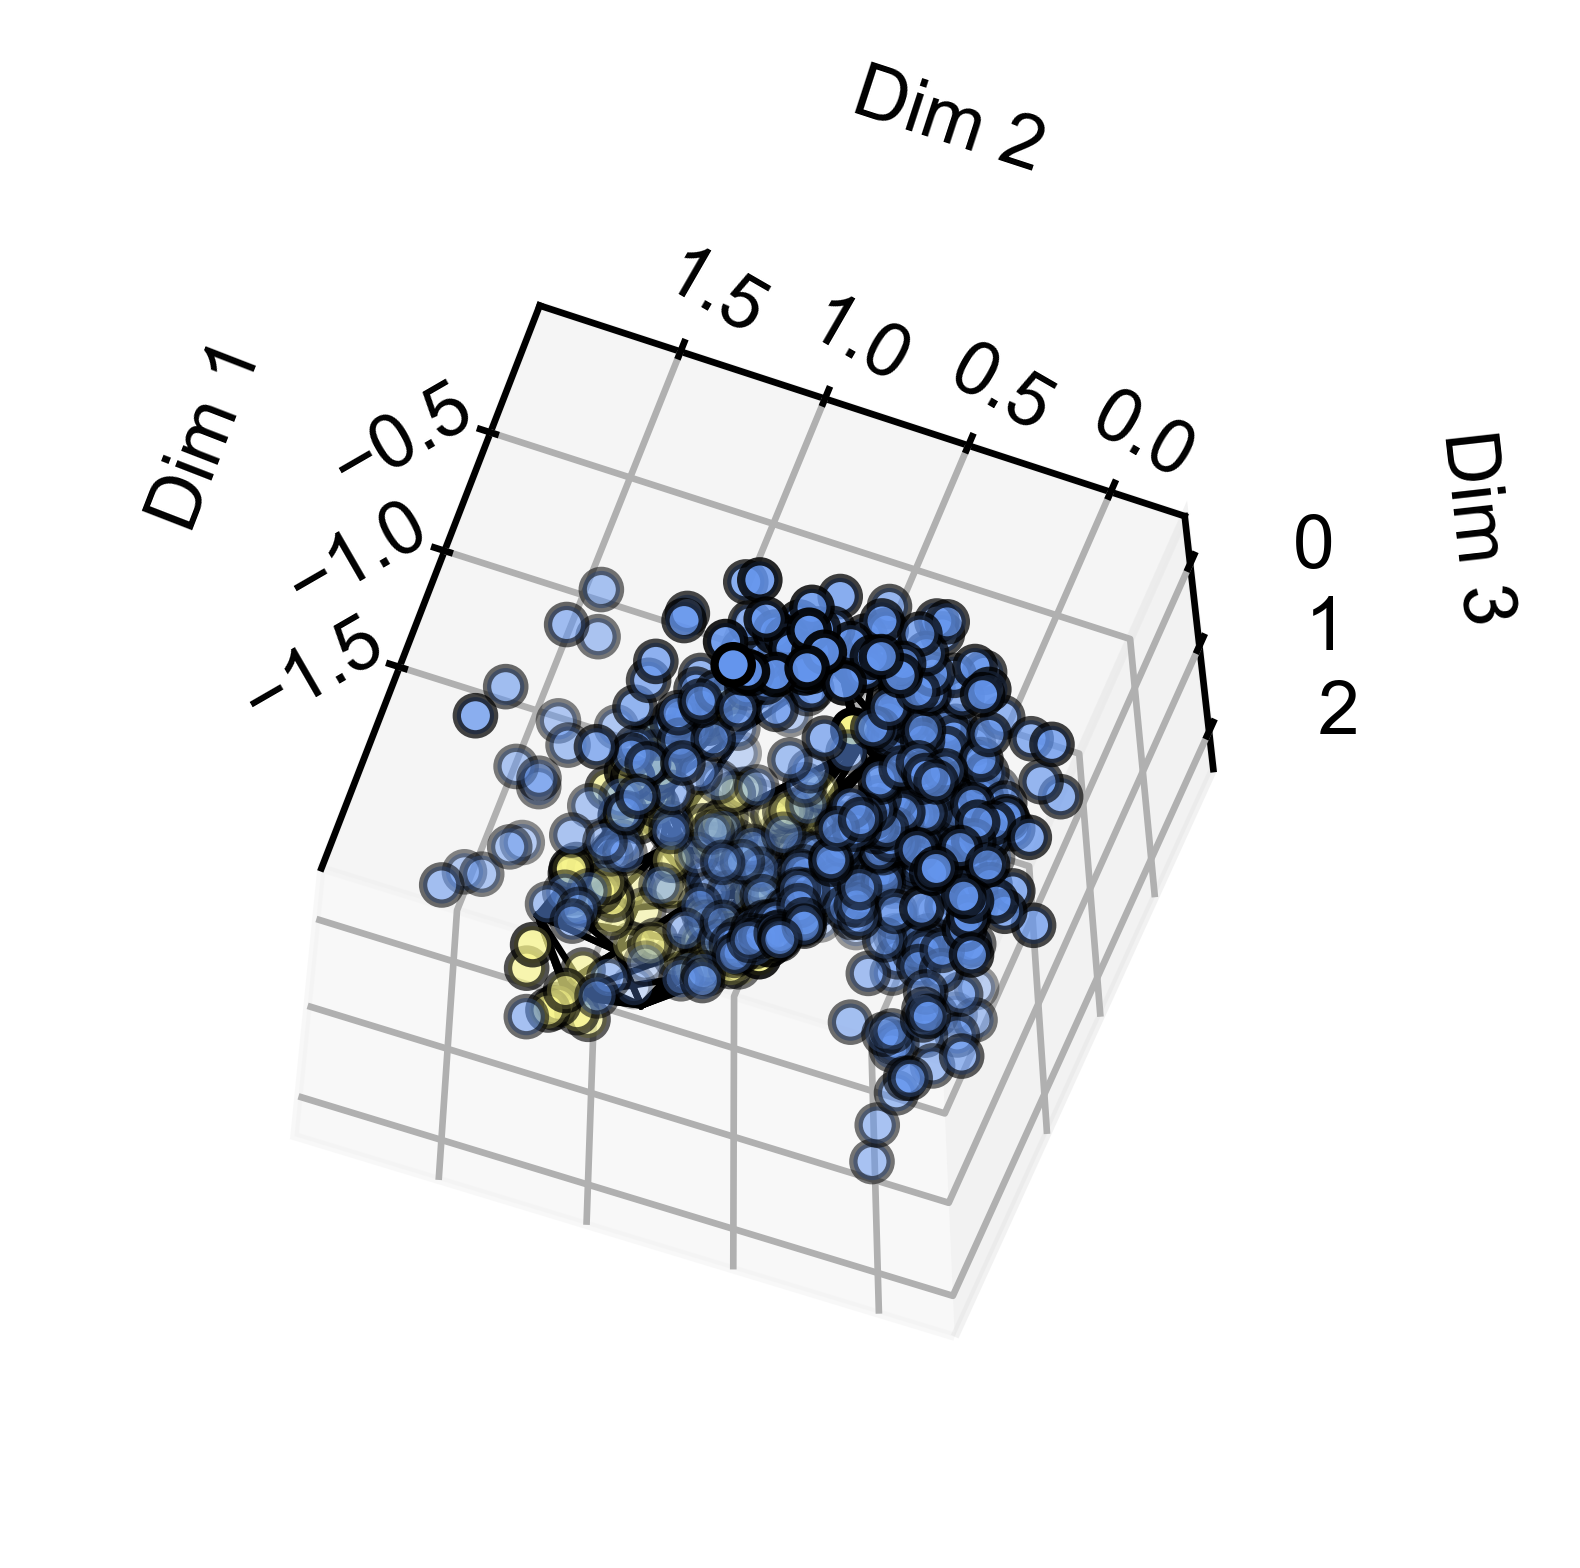

In [20]:
 for fig_idx, rot_val in zip([0], [-160]):
    fig = plt.figure(figsize = (2.5,2.5),dpi = 600)

    ax = plt.axes(projection="3d")
    ax.view_init(120, rot_val)

    # plot all of the nonfunctional embeddings in the convex hull ...
    
    p = ax.scatter(
        nonfunc_outhull_localmmd_z[:, 0],
        nonfunc_outhull_localmmd_z[:, 1],
        nonfunc_outhull_localmmd_z[:, 2],
        c = 'cornflowerblue', 
        edgecolor = 'k', 
        s = 20
    )
                   
        
    
    # plot all of the functional embeddings in the convex hull ...
    p = ax.scatter(
        func_outhull_localmmd_z[:,0],
        func_outhull_localmmd_z[:,1], 
        func_outhull_localmmd_z[:,2],
        c='#F7F48B',
        edgecolor = 'k',
        s = 20
    )

    

    for simplex in func_ortho_hull.simplices:
        ax.plot(func_ortho_mmd[simplex, 0], func_ortho_mmd[simplex, 1],  func_ortho_mmd[simplex, 2], 'k-',lw=.8)

    ax.set_xlabel('Dim 1', labelpad=9)
    ax.set_ylabel('Dim 2', labelpad=9)
    ax.set_zlabel('Dim 3')
    ax.dist = 12.4
    plt.yticks(rotation=-30)
    plt.xticks([-1.5,-1,-.5],rotation=30)
plt.tight_layout()
#plt.savefig('figures/b.pdf')

 ## Plot hull distribution:

In [24]:
# compute the total number and functional number of Sho1 in hull
num_sho1_in_hull =  sum(nonfunc_sho1_in_hull) + sum(func_sho1_in_hull)
num_func_sho1_in_hull = sum(func_sho1_in_hull)
perc_nat_sho1 = round(num_func_sho1_in_hull / num_sho1_in_hull *100, 1)
print(f'Total, functional number, and rescue percentage of natural Sho1s in convex hull: {num_sho1_in_hull}, {num_func_sho1_in_hull}, and {perc_nat_sho1}')

# compute the total number and nonfunctional number of Sho1 outside hull
num_sho1_out_hull =  sum(~nonfunc_sho1_in_hull) 
num_func_sho1_out_hull = 0
perc_nat_sho1_out_hull = round(num_func_sho1_out_hull / num_sho1_out_hull *100, 1)
print(f'Total, functional number, and rescue percetange of natural Sho1s outside convex hull: {num_sho1_out_hull}, {num_func_sho1_out_hull}, and {perc_nat_sho1_out_hull}')


# compute the total number and functional of local mmd designs in hull
num_localmmd_in_hull =  func_inhull_localmmd_df.shape[0] + nonfunc_inhull_localmmd_df.shape[0]
num_func_localmmd_in_hull = func_inhull_localmmd_df.shape[0]
perc_localmmd_in_hull = round(num_func_localmmd_in_hull / num_localmmd_in_hull *100, 1)
print(f'Total, functional number, and rescue percentage of local designs in convex hull: {num_localmmd_in_hull}, {num_func_localmmd_in_hull}, and {perc_localmmd_in_hull}')


# compute the total number and functional of local mmd designs outside hull
num_localmmd_out_hull =  func_outhull_localmmd_df.shape[0] + nonfunc_outhull_localmmd_df.shape[0]
num_func_localmmd_out_hull = func_outhull_localmmd_df.shape[0]
perc_localmmd_out_hull = round(num_func_localmmd_out_hull / num_localmmd_out_hull *100, 1)
print(f'Total, functional number, and rescue percetange of global designs outside convex hull: {num_localmmd_out_hull}, {num_func_localmmd_out_hull}, and {perc_localmmd_out_hull}')


Total, functional number, and rescue percentage of natural Sho1s in convex hull: 164, 141, and 86.0
Total, functional number, and rescue percetange of natural Sho1s outside convex hull: 14, 0, and 0.0
Total, functional number, and rescue percentage of local designs in convex hull: 387, 294, and 76.0
Total, functional number, and rescue percetange of global designs outside convex hull: 600, 140, and 23.3


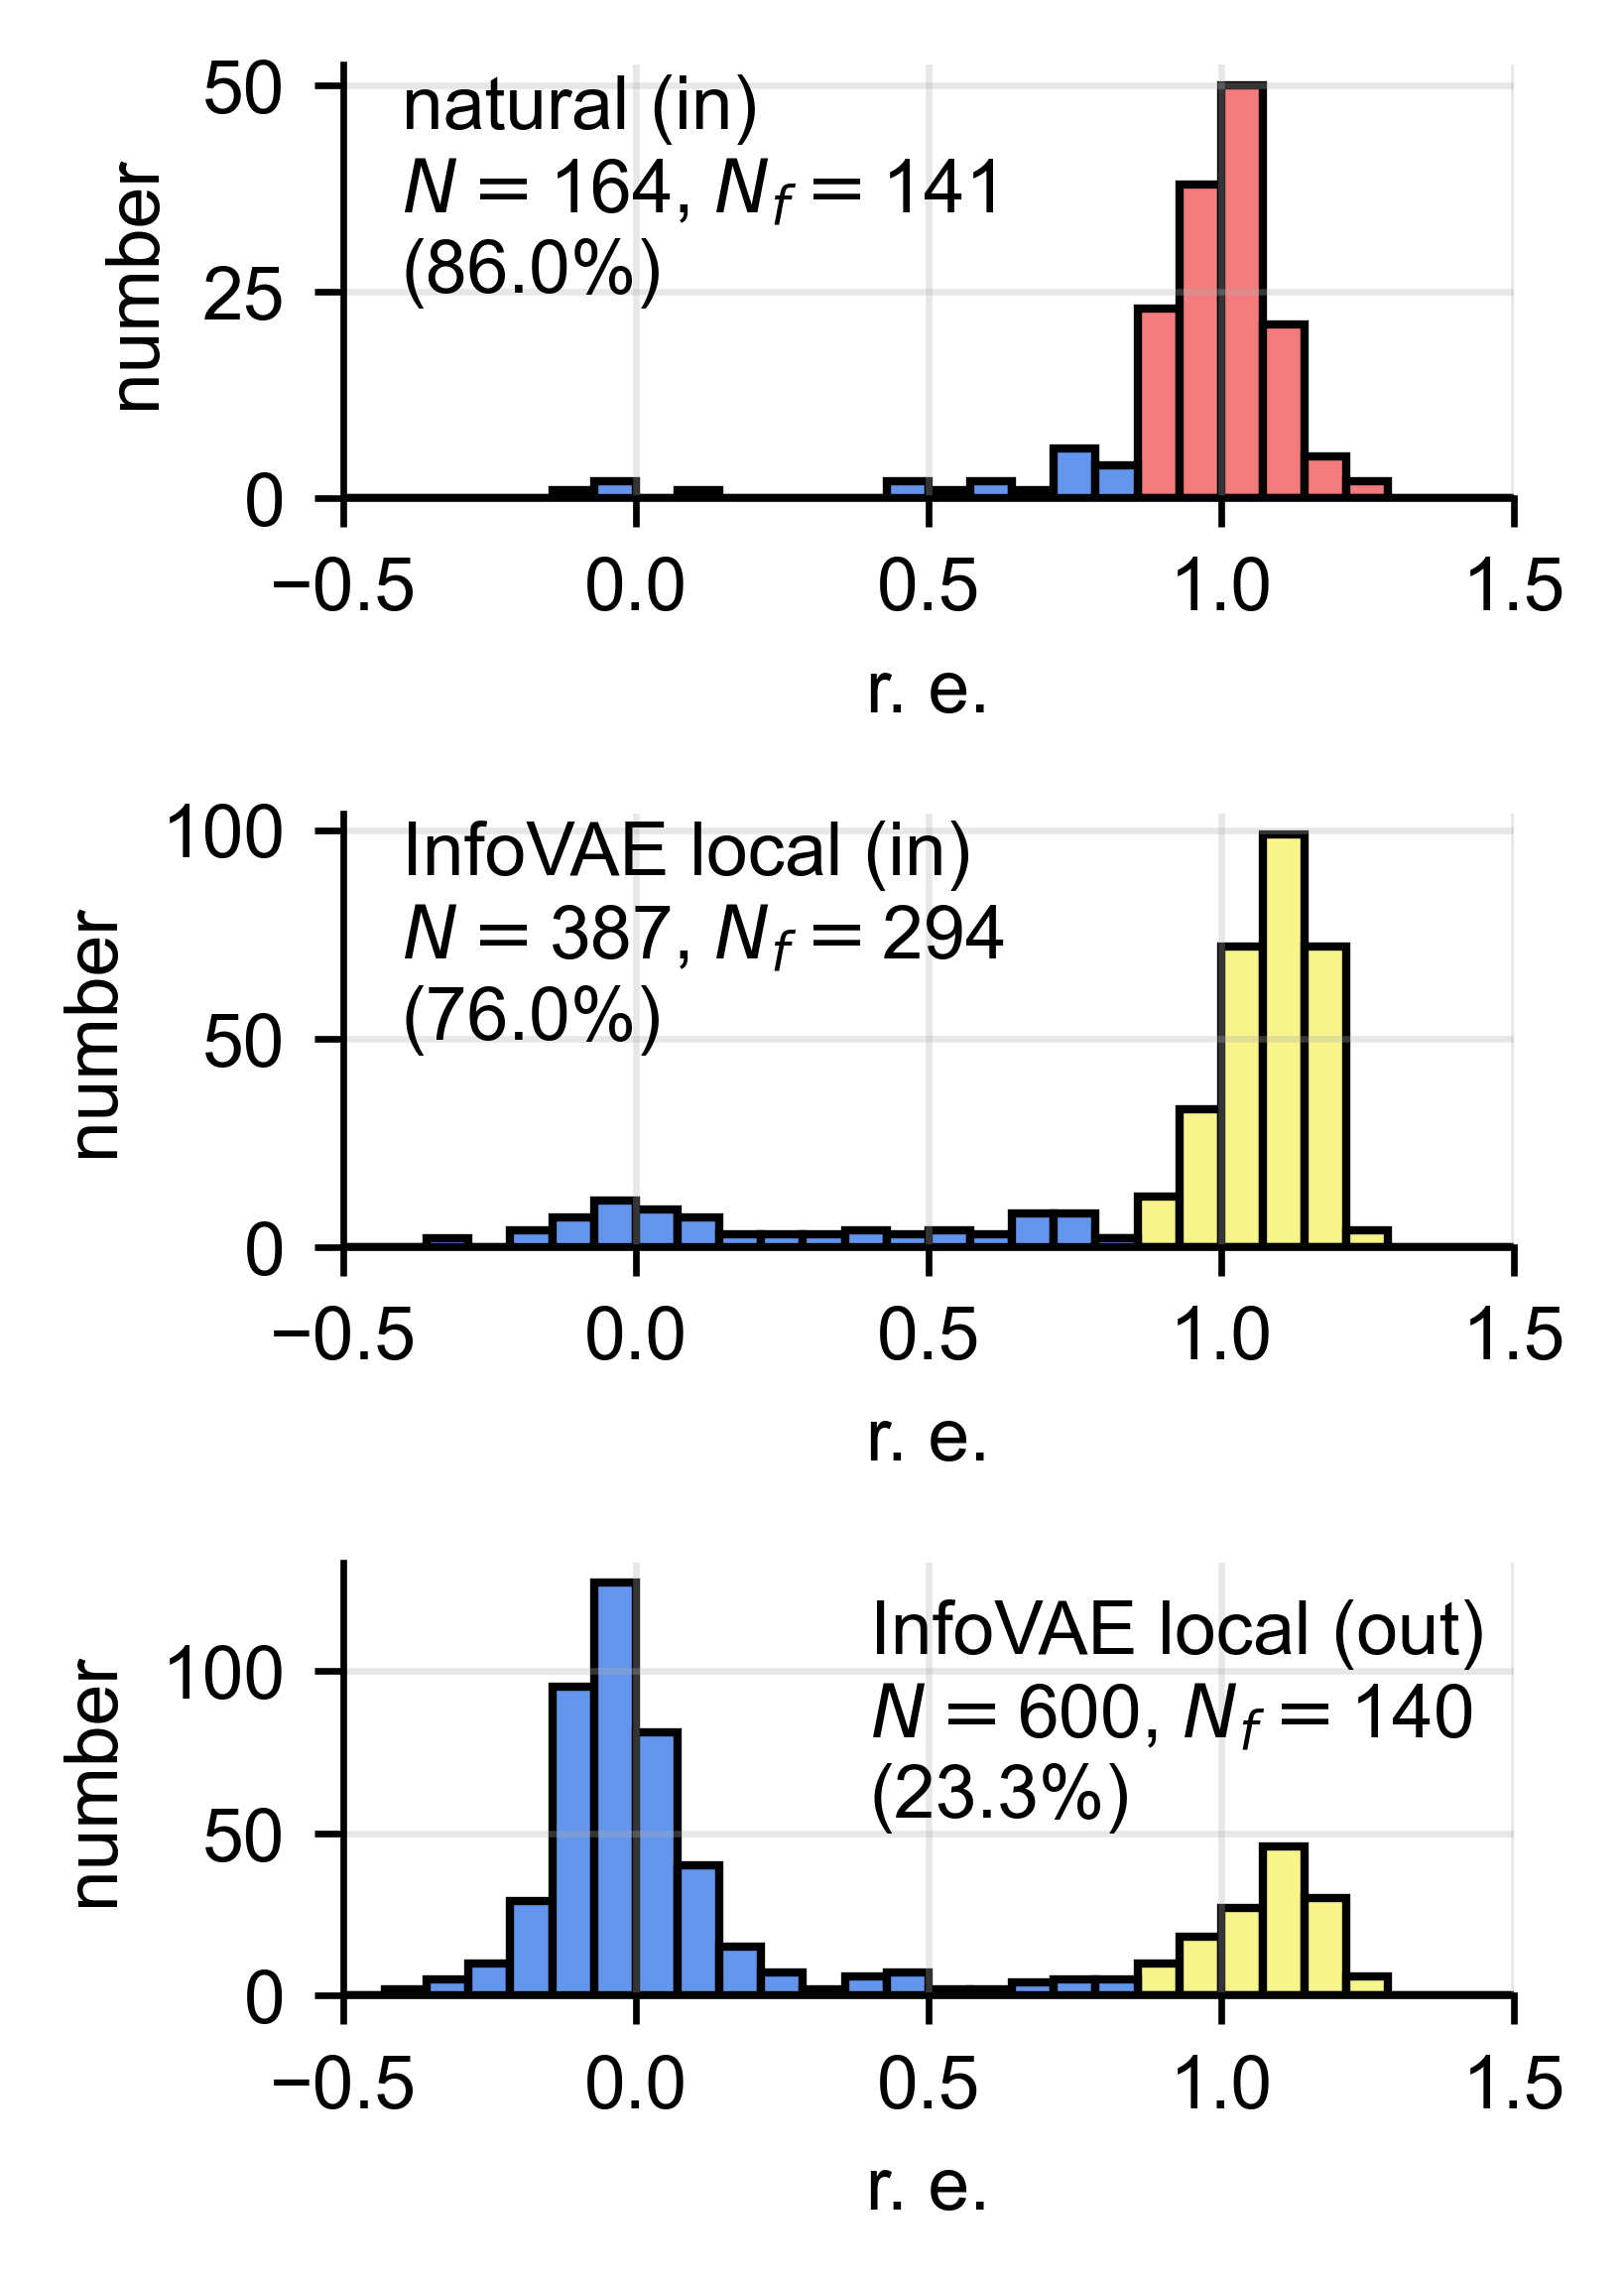

In [25]:

fig,axs=plt.subplots(3,1,figsize=[2.8,3.9],dpi=600)
patches=[0,0,0]

# plot the bimodal distribution of natural SH3 domains in the convex hull ...
# functional ...
N_hist1, bins, patches[0]=axs[0].hist(
    func_sho1_all_df.iloc[func_sho1_in_hull].norm_RE,
    np.linspace(-.5,1.5,29),
    color='#f47b7b',
    edgecolor='k'
)
# non-functional
N_hist1, bins, patches[0]=axs[0].hist(
    nonfunc_sho1_all_df.iloc[nonfunc_sho1_in_hull].norm_RE,
    np.linspace(-.5,1.5,29),
    color='cornflowerblue',
    edgecolor='k'
)

# plot the bimodal distribution of local MMD-VAE in the convex hull ...
# functional 
N_hist1, bins, patches[1]=axs[1].hist(
    func_inhull_localmmd_df.RE_norm,
    np.linspace(-.5,1.5,29),
    color='#F7F48B',
    edgecolor='k'
)

# nonfunctional
N_hist1, bins, patches[1]=axs[1].hist(
    nonfunc_inhull_localmmd_df.RE_norm,
    np.linspace(-.5,1.5,29),
    color='cornflowerblue',
    edgecolor='k'
)

# plot the bimodal distribution of local MMD-VAE outside the convex hull ...
# functional
N_hist1, bins, patches[2]=axs[2].hist(
    func_outhull_localmmd_df.RE_norm,
    np.linspace(-.5,1.5,29),
    color='#F7F48B',
    edgecolor='k'
)

N_hist1, bins, patches[2]=axs[2].hist(
    nonfunc_outhull_localmmd_df.RE_norm,
    np.linspace(-.5,1.5,29),
    color='cornflowerblue',
    edgecolor='k'
)

#plt.setp(axs[0].get_xticklabels(), visible=False)
#plt.setp(axs[1].get_xticklabels(), visible=False)

axs[0].set_yticks([0,25,50])
axs[1].set_yticks([0,50,100])
axs[2].set_yticks([0,50,100])
axs[0].text(-.4,25, 'natural (in)\n$N = $' + str(num_sho1_in_hull) + ', $N_f =$'+str(num_func_sho1_in_hull)+'\n('+str(perc_nat_sho1)+'%)')
axs[1].text(-.4,50, 'InfoVAE local (in)\n$N = $' + str(num_localmmd_in_hull) + ', $N_f =$'+str(num_func_localmmd_in_hull)+'\n('+str(perc_localmmd_in_hull)+'%)')
axs[2].text(.4,55, 'InfoVAE local (out)\n$N = $' + str(num_localmmd_out_hull) + ', $N_f =$'+str(num_func_localmmd_out_hull)+'\n('+str(perc_localmmd_out_hull)+'%)')
for i in range(3):
    axs[i].set_xlabel('r. e.')
    axs[i].set_ylabel('number')
    axs[i].set_xlim(-.5,1.5)
    axs[i].grid(alpha=.3)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
    for j in range(0,14): 
        patches[i][j].set_facecolor('cornflowerblue')
plt.tight_layout()
#plt.savefig('figures/rehull.pdf')
plt.show()

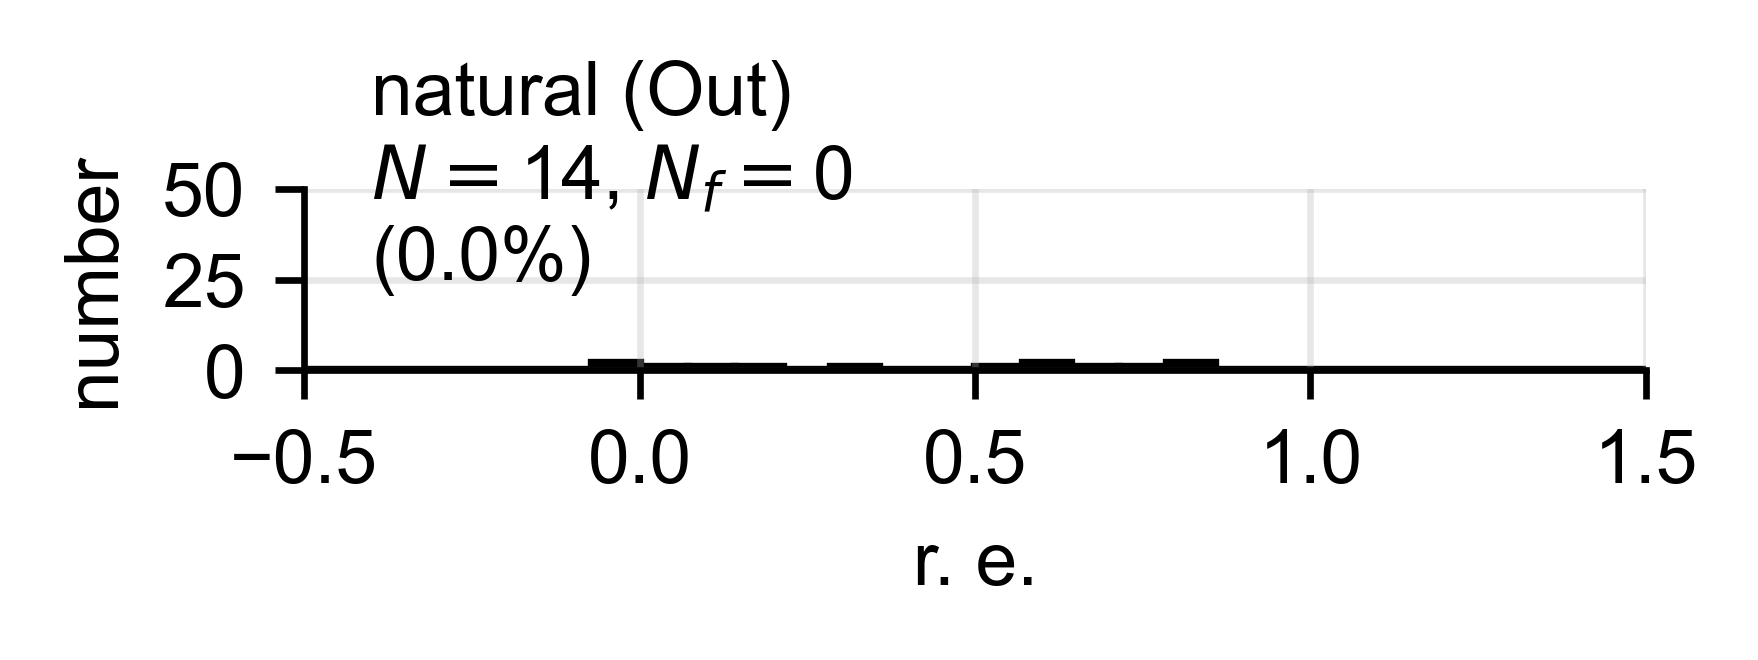

In [26]:
plt.figure(figsize=[3,1],dpi=600)
patches=[0,0,0]

ax = plt.subplot(111)
N_hist1, bins, patches[0] = ax.hist(
    nonfunc_sho1_all_df.iloc[~nonfunc_sho1_in_hull].norm_RE,
    np.linspace(-.5,1.5,29),
    color='cornflowerblue',
    edgecolor='k'
)



ax.set_yticks([0,25,50])
ax.text(-.4,25, 'natural (Out)\n$N = $' + str(num_sho1_out_hull) + ', $N_f =$'+str(num_func_sho1_out_hull)+'\n('+str(perc_nat_sho1_out_hull)+'%)')
for i in range(1):
    ax.set_xlabel('r. e.')
    ax.set_ylabel('number')
    ax.set_xlim(-.5,1.5)
    plt.grid(alpha=.3)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for j in range(0,14):
        patches[i][j].set_facecolor('cornflowerblue')
plt.tight_layout()
#plt.savefig('figures/rehull.pdf')
plt.show()